# House Price (Advance Regression Technique)

## Feature Engineering

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# for the yeo-johnson transformation
import scipy.stats as stats

# to divide train and test set
from sklearn.model_selection import train_test_split

# feature scaling
from sklearn.preprocessing import MinMaxScaler

# to save the trained scaler class
import joblib

import warnings

warnings.filterwarnings("ignore")

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

**Reload dataset**

In [2]:
def import_(filepath):
    df = pd.read_csv(filepath)
    return df

In [3]:
data = import_('train.csv')

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,NaN,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


**Separate dataset into train and test**

It is important to separate our data into training and testing set.

When we engineer features, some techniques learn parameters from data. It is important to learn these parameters only from the train set. This is done to avoid over-fitting.


In [5]:
# Let's separate into train and test set

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(columns=['Id', 'SalePrice']),  # getting only the predictive variables
    data['SalePrice'],   # target variable
    test_size=0.1,
    random_state=0
)

print("shape X_train: ", X_train.shape)
print("Shape y_train: ", y_train.shape)
print("Shape X_test: ", X_test.shape)
print("Shape y_test: ", y_test.shape)

shape X_train:  (1314, 79)
Shape y_train:  (1314,)
Shape X_test:  (146, 79)
Shape y_test:  (146,)


We will engineer the variables of the House Price Dataset so that we tackle the following:
1. Missing Values
2. Temporal Variables 
3. Non-Gaussian distribution variables
4. Categorical Variable: remove rare labels
5. Categorical Variables: convert strings to numbers
6. Put the variables in a similar scale

**Target Variable**

Apply logarithm function to the output variable to obtain Gaussian distribution.

In [6]:
y_train = np.log(y_train)
y_test = np.log(y_test)

**Missing Values**

**categorical variables**: We will replace missing values with string "missing" in those variables with a lot of missing data.

Alternatively, we will replace missing data with the most frequent category in those variables that contains fewer observations without values.



In [7]:
# let's identify the categorical variables
# we will capture those of type object

cat_vars = [var for var in data.columns if data[var].dtype == 'O']

# MSSubClass is also categorical by definition, despite its numeric values
# (you can find the definitions of the variables in the data_description.txt
# file available on Kaggle, in the same website where you downloaded the data)

# lets add MSSubClass to the list of categorical variables
cat_vars = cat_vars + ['MSSubClass']

# cast all variables as categorical
X_train[cat_vars] = X_train[cat_vars].astype('O')
X_test[cat_vars] = X_test[cat_vars].astype('O')

# number of categorical variables
len(cat_vars)

44

In [8]:
# make a list of the categorical variables that contain missing values

cat_vars_with_na = [
    var for var in cat_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[cat_vars_with_na ].isnull().mean().sort_values(ascending=False)

PoolQC          0.995434
MiscFeature     0.961187
Alley           0.938356
Fence           0.814307
MasVnrType      0.601218
FireplaceQu     0.472603
GarageType      0.056317
GarageFinish    0.056317
GarageQual      0.056317
GarageCond      0.056317
BsmtExposure    0.025114
BsmtFinType2    0.025114
BsmtQual        0.024353
BsmtCond        0.024353
BsmtFinType1    0.024353
Electrical      0.000761
dtype: float64

In [9]:
# variables to impute with the string missing
with_string_missing = [
    var for var in cat_vars_with_na if X_train[var].isna().mean() > 0.1
]

# variables to imput with the most frequent category
with_frequent_category = [
    var for var in cat_vars_with_na if X_train[var].isna().mean() < 0.1
]

In [10]:
with_string_missing

['Alley', 'MasVnrType', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [11]:
# Replace missing value with new label: "Missing"
X_train[with_string_missing] = X_train[with_string_missing].fillna("Missing")
X_test[with_string_missing] = X_test[with_string_missing].fillna("Missing")

In [12]:
for var in with_frequent_category:
    # There can be more than one mode in a variable
    # We will pick on the first one
    mode = X_train[var].mode()[0]
    
    print(f"{var} (mode): {mode}")
    
    X_train[var].fillna(mode, inplace=True)
    X_test[var].fillna(mode, inplace=True)

BsmtQual (mode): TA
BsmtCond (mode): TA
BsmtExposure (mode): No
BsmtFinType1 (mode): Unf
BsmtFinType2 (mode): Unf
Electrical (mode): SBrkr
GarageType (mode): Attchd
GarageFinish (mode): Unf
GarageQual (mode): TA
GarageCond (mode): TA


In [13]:
# check that we have no missing information in the engineered variables

X_train[cat_vars_with_na].isnull().sum()

Alley           0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

In [14]:
# check that test set does not contain null values in the engineered variables

[var for var in cat_vars_with_na if X_test[var].isnull().sum() > 0]

[]

**Numerical Variables**

To engineer missing values in numerical variables, we will do the following:
- Add a binary missing indicator variable
- Then replace the missing values in the original variable with the mean

In [15]:
# now let's identify the numerical variables

num_vars = [
    var for var in X_train.columns if var not in cat_vars and var != 'SalePrice'
]

# number of numerical variables
len(num_vars)

35

In [16]:
# make a list with the numerical variables that contain missing values
vars_with_na = [
    var for var in num_vars
    if X_train[var].isnull().sum() > 0
]

# print percentage of missing values per variable
X_train[vars_with_na].isnull().mean()

LotFrontage    0.177321
MasVnrArea     0.004566
GarageYrBlt    0.056317
dtype: float64

In [17]:
# Replace missing values and create missing values indicator

for var in vars_with_na:
    # calculate the mean value of the train set
    mean_val = X_train[var].mean()
    
    print(f"{var} (mean_val): {mean_val}")
    
    # add binary missing indicator
    X_train[var + "_na"] = np.where(X_train[var].isna(),1,0)
    X_test[var + "_na"] = np.where(X_test[var].isna(),1,0)
    
    # replace missing values with the mean_val
    X_train[var].fillna(mean_val, inplace=True)
    X_test[var].fillna(mean_val, inplace=True)
    

LotFrontage (mean_val): 69.87974098057354
MasVnrArea (mean_val): 103.7974006116208
GarageYrBlt (mean_val): 1978.2959677419356


In [18]:
# checking for missing in X_train
X_train[vars_with_na].isna().sum()

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [19]:
# checking for missing values in X_test
[var for var in vars_with_na if X_test[var].isnull().sum() > 0]

[]

In [20]:
# check for binary missing indicator variable
X_train[['LotFrontage_na', 'MasVnrArea_na', 'GarageYrBlt_na']].head()

,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
930,0,0,0
656,0,0,0
45,0,0,0
1348,1,0,0
55,0,0,0


**Temporal Variable**


**capture elapsed time**: We will capture the time elapsed between variables such as year in which the house or the garage were built or remodeled and the year in which the house was sold:

In [21]:
def elapse_years(df, var):
    # capture difference betwee the year variable
    # and the year in which the house was sold
    df[var] = df['YrSold'] - df[var]
    return df


In [22]:
var_year = [var for var in data.columns if 'Yr' in var or 'Year' in var]

In [23]:
for var in var_year:
    if var != "YrSold":
        X_train = elapse_years(X_train, var)
        X_test = elapse_years(X_test, var)

In [24]:
X_test.drop(columns='YrSold', inplace=True)
X_train.drop(columns='YrSold', inplace=True)

In [25]:
X_test[var_year[:3]].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
529,50,32,32.0
491,65,56,65.0
459,59,59,59.0
279,31,31,31.0
655,39,39,39.0


**Numerical Variable Transformation**

**Logarithm Transformation**

We have already made observations that most of the numerical variables are not normally distributed. Logarithmic function will be applies to most of the numerical variables to achieve a more Gaussian looking distribution.

In [26]:
for var in ['LotArea', 'LotFrontage', '1stFlrSF', 'GrLivArea']:
    X_train[var] = np.log(X_train[var])
    X_test[var] = np.log(X_test[var])

In [27]:
# check if test set contains null values
[var for val in ['LotArea', 'LotFrontage', '1stFlrSF', 'GrLivArea'] if X_test[var].isna().sum() > 0]

[]

In [28]:
# check if train set contains null values
[var for val in ['LotArea', 'LotFrontage', '1stFlrSF', 'GrLivArea'] if X_train[var].isna().sum() > 0]

[]

In [29]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [30]:
# check absence of na in the test set
[var for var in X_train.columns if X_test[var].isnull().sum() > 0]

[]

**Binary Skewed Variables**

There were a few variables very skewed, we would transform those into binary variables.

In [31]:
skewed = [
    'BsmtFinSF2', 'LowQualFinSF', 'EnclosedPorch',
    '3SsnPorch', 'ScreenPorch', 'MiscVal'
]

for var in skewed:
    # map the variable values into 0 and 1
    X_train[var] = np.where(X_train[var]==0, 0, 1)
    X_test[var] = np.where(X_test[var]==0, 0, 1)

**Categorical Variables**



In [32]:
# re-map strings to numbers, which determine quality

qual_mappings = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5, 'Missing': 0, 'NA': 0}

qual_vars = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
             'HeatingQC', 'KitchenQual', 'FireplaceQu',
             'GarageQual', 'GarageCond',
            ]

for var in qual_vars:
    X_train[var] = X_train[var].map(qual_mappings)
    X_test[var] = X_test[var].map(qual_mappings)

In [33]:
exposure_mappings = {'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}

var = 'BsmtExposure'

X_train[var] = X_train[var].map(exposure_mappings)
X_test[var] = X_test[var].map(exposure_mappings)

In [34]:
finish_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}

finish_vars = ['BsmtFinType1', 'BsmtFinType2']

for var in finish_vars:
    X_train[var] = X_train[var].map(finish_mappings)
    X_test[var] = X_test[var].map(finish_mappings)

In [35]:
garage_mappings = {'Missing': 0, 'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}

var = 'GarageFinish'

X_train[var] = X_train[var].map(garage_mappings)
X_test[var] = X_test[var].map(garage_mappings)


In [36]:
fence_mappings = {'Missing': 0, 'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}

var = 'Fence'

X_train[var] = X_train[var].map(fence_mappings)
X_test[var] = X_test[var].map(fence_mappings)

In [37]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

**Removing Rare Labels**

For the categorical variables, we will group those categories that are present in less than 1% of the observations. That is, all values of categorical variables that are shared by less than 1% of houses, will be replaced by string "Rare"

In [38]:
# capture all quality variables

qual_vars  = qual_vars + finish_vars + ['BsmtExposure','GarageFinish','Fence']

# capture the remaining categorical variables
# (those that we did not re-map)

cat_others = [
    var for var in cat_vars if var not in qual_vars
]

len(cat_others)

30

In [39]:
def find_frequent_labels(df, var, rare_perc):
    
    """
    The function finds the labels that are shared by more than 
    a certain % of the houses in the dataset
    
    df: Dataframe
    
    var: the variable to inspect
    
    rare_perc: percentage value
    """
    df = df.copy()
    
    tmp = df[var].value_counts(normalize=True)
    
    return tmp[tmp > rare_perc].index



In [40]:
for var in cat_others:
    # find the frequent categories
    frequent_ls = find_frequent_labels(X_train, var, 0.01)
    print(f'{var} (frequent labels): {frequent_ls}')
    
    print()
    
    # replace reare categories by the string "Rare"
    X_train[var] = np.where(X_train[var].isin(frequent_ls), X_train[var], "Rare")
    
    X_test[var] = np.where(X_test[var].isin(frequent_ls), X_test[var], 'Rare')

MSZoning (frequent labels): Index(['RL', 'RM', 'FV', 'RH'], dtype='object', name='MSZoning')

Street (frequent labels): Index(['Pave'], dtype='object', name='Street')

Alley (frequent labels): Index(['Missing', 'Grvl', 'Pave'], dtype='object', name='Alley')

LotShape (frequent labels): Index(['Reg', 'IR1', 'IR2'], dtype='object', name='LotShape')

LandContour (frequent labels): Index(['Lvl', 'Bnk', 'HLS', 'Low'], dtype='object', name='LandContour')

Utilities (frequent labels): Index(['AllPub'], dtype='object', name='Utilities')

LotConfig (frequent labels): Index(['Inside', 'Corner', 'CulDSac', 'FR2'], dtype='object', name='LotConfig')

LandSlope (frequent labels): Index(['Gtl', 'Mod'], dtype='object', name='LandSlope')

Neighborhood (frequent labels): Index(['NAmes', 'CollgCr', 'OldTown', 'Edwards', 'Somerst', 'NridgHt',
       'Gilbert', 'Sawyer', 'NWAmes', 'BrkSide', 'SawyerW', 'Crawfor',
       'Mitchel', 'Timber', 'NoRidge', 'IDOTRR', 'ClearCr', 'SWISU', 'StoneBr',
       'Blmngt

**Encoding of Categorical Variables**

We need to transform the strings of the 

In [41]:
# this function wiil assign discrete values to the strings of the variables,
# so that the s,aller value corresponds to the category that shows 
# smaller mean house sale price

def replace_categories(train, test, y_train, val, target):
    temp = pd.concat([X_train, y_train], axis=1)
    
    # order the categories in a variable from that with the lowest mean
    # house sale price, to that with the highest
    ordered_labels = temp.groupby(var)[target].mean().sort_values().index
    
    map_labels = {k: i for i, k in enumerate(ordered_labels)}
    
    print(f"{var} (labels): {map_labels}")
    print()
    
    # us the dicitonary to replace the categorical strings by integer
    train[var] = train[var].map(map_labels)
    test[var] = test[var].map(map_labels)
    
    
    

In [42]:
X_train[cat_others].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,Heating,CentralAir,Electrical,Functional,GarageType,PavedDrive,PoolQC,MiscFeature,SaleType,SaleCondition,MSSubClass
930,RL,Pave,Missing,IR1,HLS,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,Missing,PConc,GasA,Y,SBrkr,Typ,Attchd,Y,Missing,Missing,WD,Normal,20
656,RL,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,HdBoard,BrkFace,CBlock,GasA,Y,SBrkr,Typ,Attchd,Y,Missing,Missing,WD,Normal,20
45,RL,Pave,Missing,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,TwnhsE,1Story,Hip,CompShg,MetalSd,MetalSd,BrkFace,PConc,GasA,Y,SBrkr,Typ,Attchd,Y,Missing,Missing,WD,Normal,120
1348,RL,Pave,Missing,Rare,Low,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,Missing,PConc,GasA,Y,SBrkr,Typ,Attchd,Y,Missing,Missing,WD,Normal,20
55,RL,Pave,Missing,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,HdBoard,Plywood,BrkFace,CBlock,GasA,Y,SBrkr,Typ,Attchd,Y,Missing,Missing,WD,Normal,20


In [52]:
for var in cat_others:
    replace_categories(X_train, X_test, y_train, var, "SalePrice")

MSZoning (labels): {'Rare': 0, 'RM': 1, 'RH': 2, 'RL': 3, 'FV': 4}

Street (labels): {'Rare': 0, 'Pave': 1}

Alley (labels): {'Grvl': 0, 'Pave': 1, 'Missing': 2}

LotShape (labels): {'Reg': 0, 'IR1': 1, 'Rare': 2, 'IR2': 3}

LandContour (labels): {'Bnk': 0, 'Lvl': 1, 'Low': 2, 'HLS': 3}

Utilities (labels): {'Rare': 0, 'AllPub': 1}

LotConfig (labels): {'Inside': 0, 'FR2': 1, 'Corner': 2, 'Rare': 3, 'CulDSac': 4}

LandSlope (labels): {'Gtl': 0, 'Mod': 1, 'Rare': 2}

Neighborhood (labels): {'IDOTRR': 0, 'MeadowV': 1, 'BrDale': 2, 'Edwards': 3, 'BrkSide': 4, 'OldTown': 5, 'Sawyer': 6, 'SWISU': 7, 'NAmes': 8, 'Mitchel': 9, 'SawyerW': 10, 'Rare': 11, 'NWAmes': 12, 'Gilbert': 13, 'Blmngtn': 14, 'CollgCr': 15, 'Crawfor': 16, 'ClearCr': 17, 'Somerst': 18, 'Timber': 19, 'StoneBr': 20, 'NridgHt': 21, 'NoRidge': 22}

Condition1 (labels): {'Artery': 0, 'Feedr': 1, 'Norm': 2, 'RRAn': 3, 'Rare': 4, 'PosN': 5}

Condition2 (labels): {'Rare': 0, 'Norm': 1}

BldgType (labels): {'2fmCon': 0, 'Duplex': 1

In [53]:
# check absence of na in the train set
[var for var in X_train.columns if X_train[var].isnull().sum() > 0]

[]

In [54]:
# check absence of na in the test set
[var for var in X_test.columns if X_test[var].isnull().sum() > 0]

[]

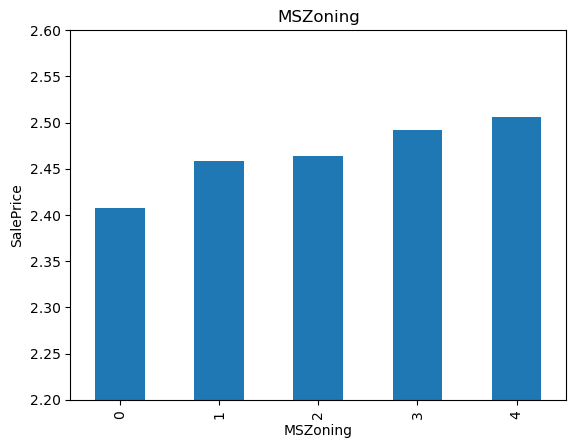

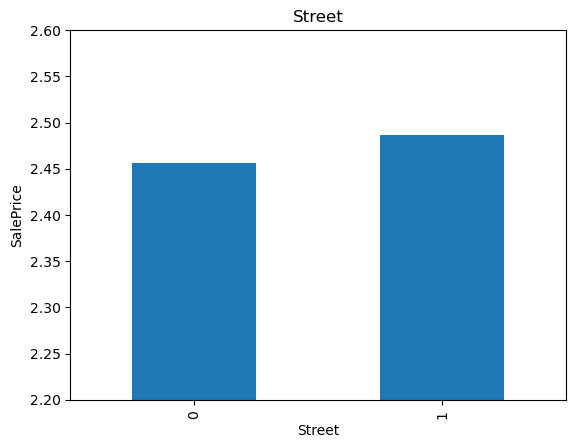

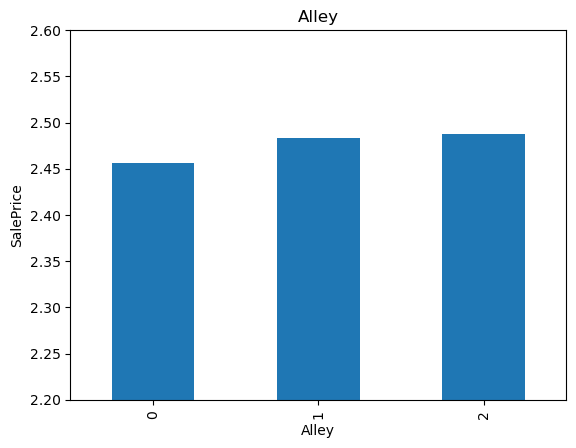

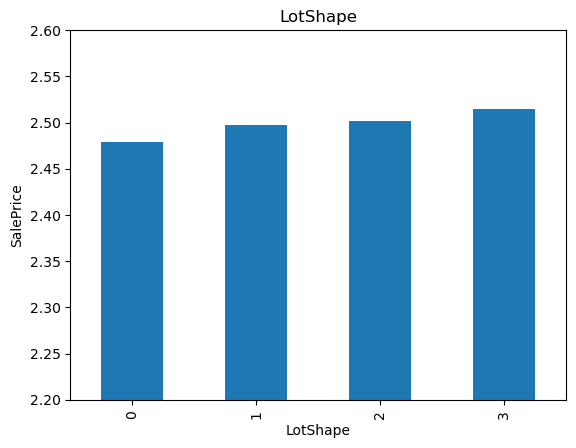

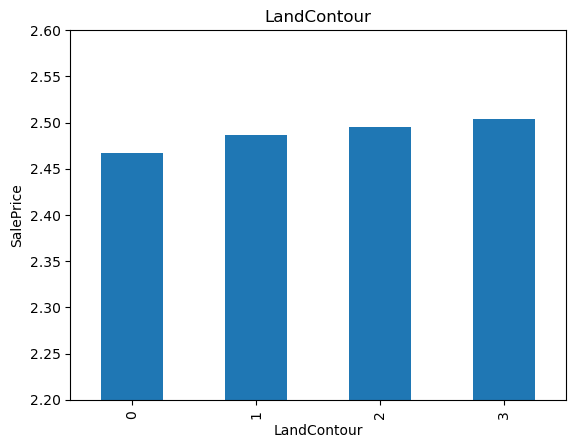

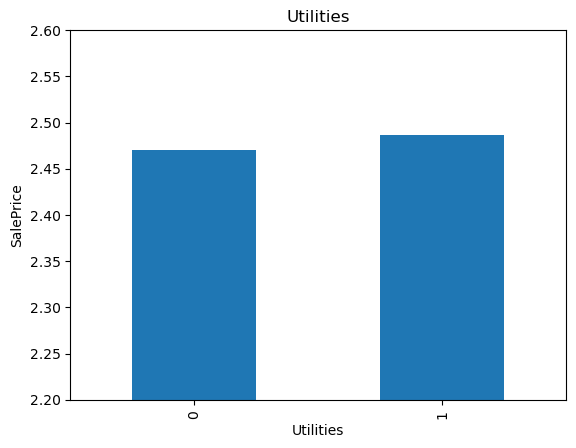

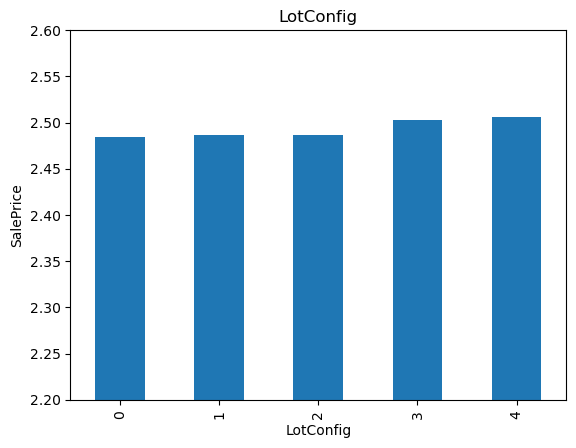

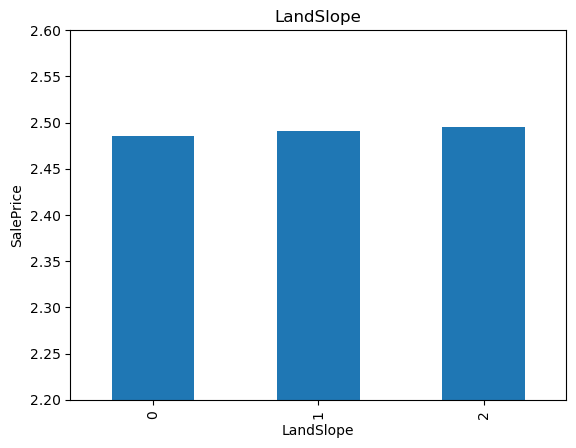

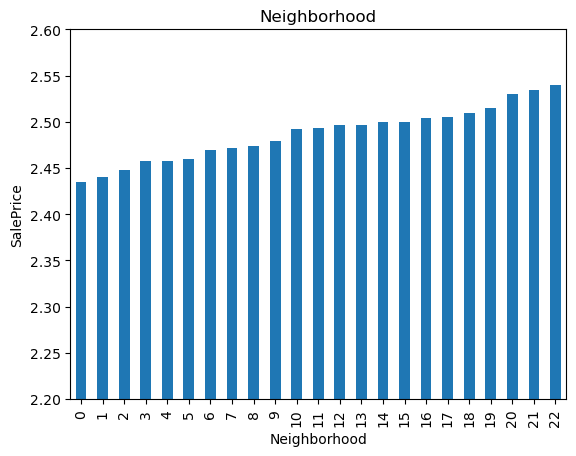

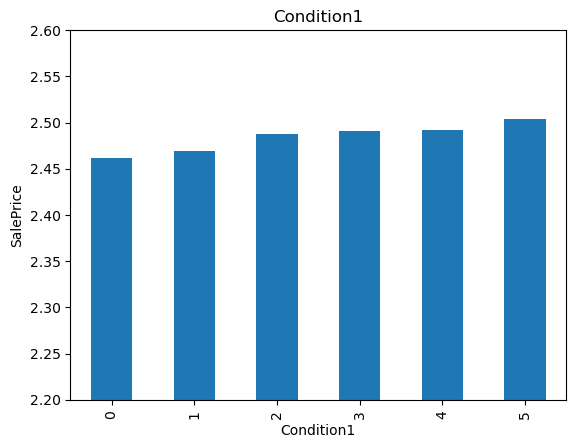

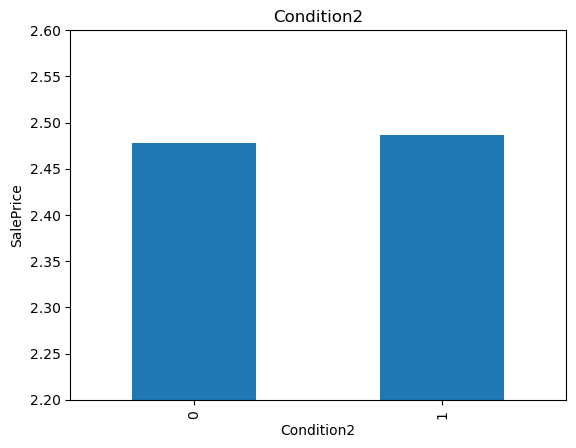

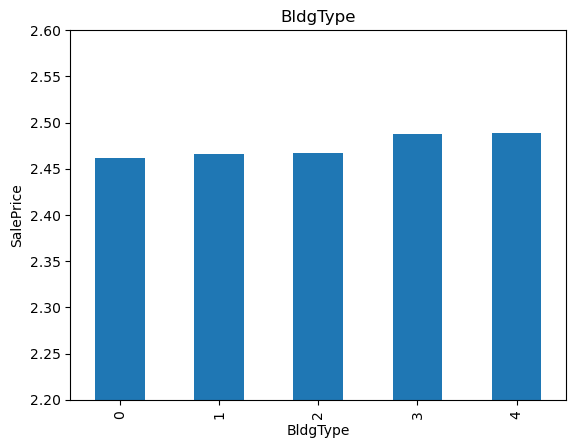

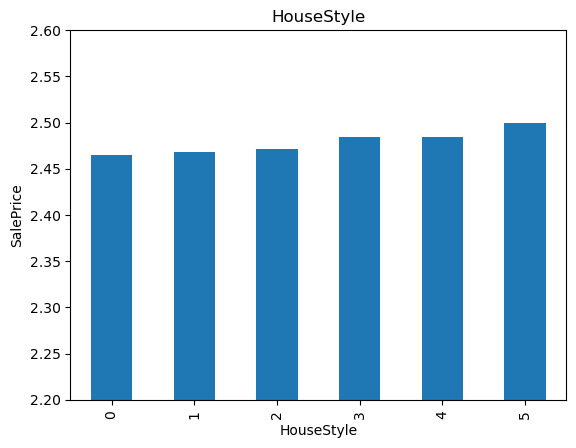

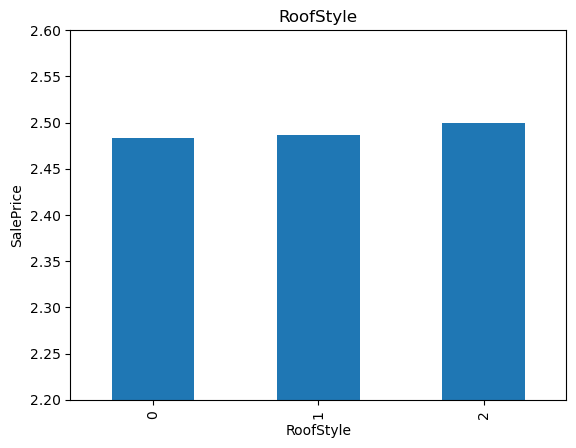

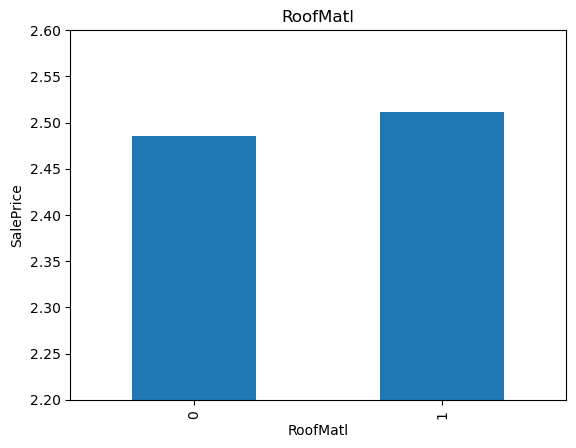

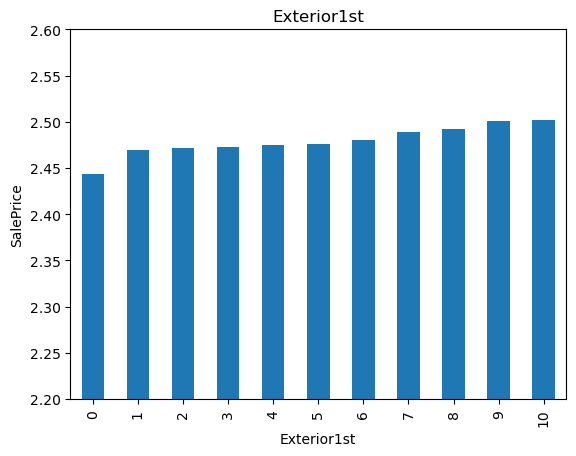

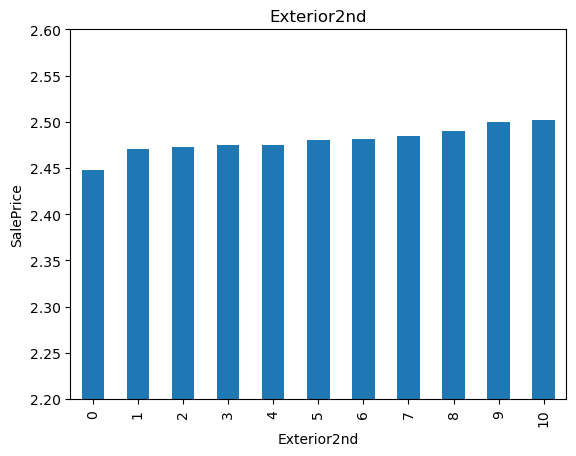

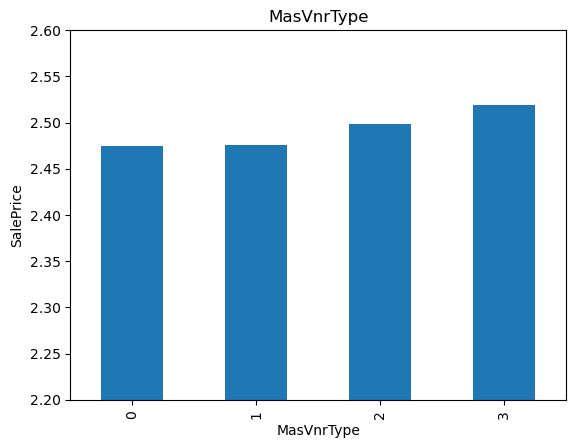

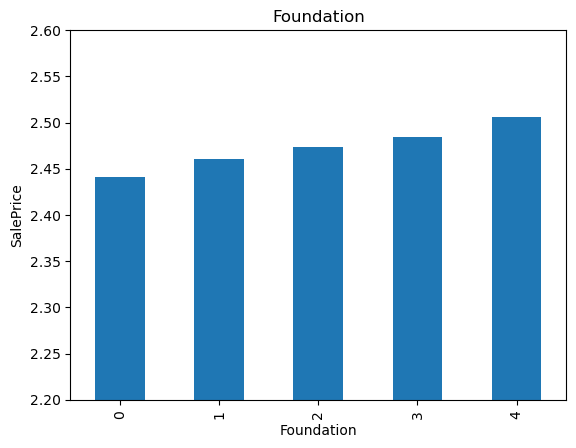

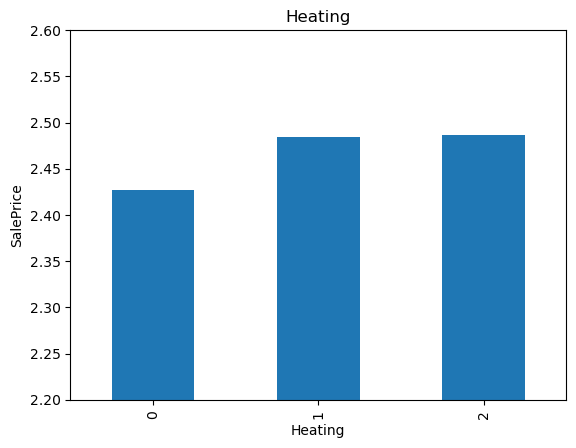

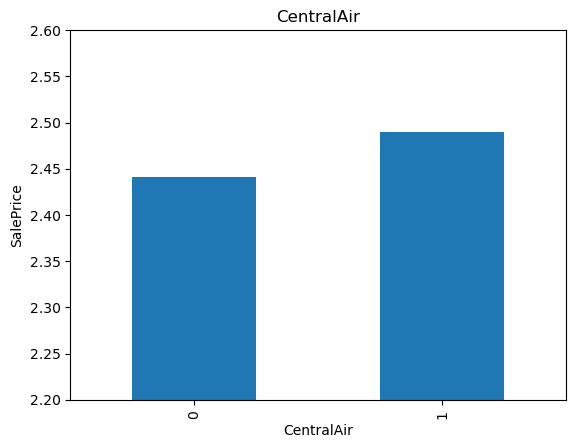

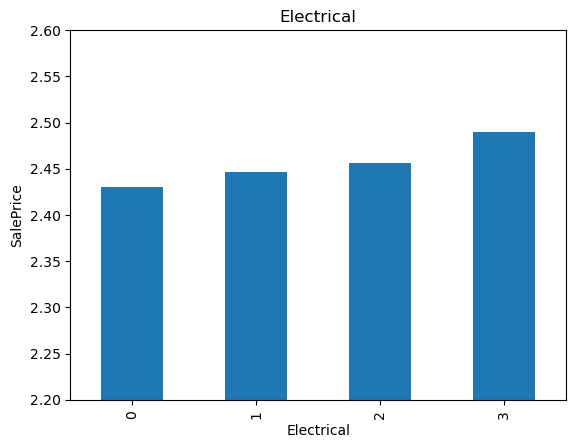

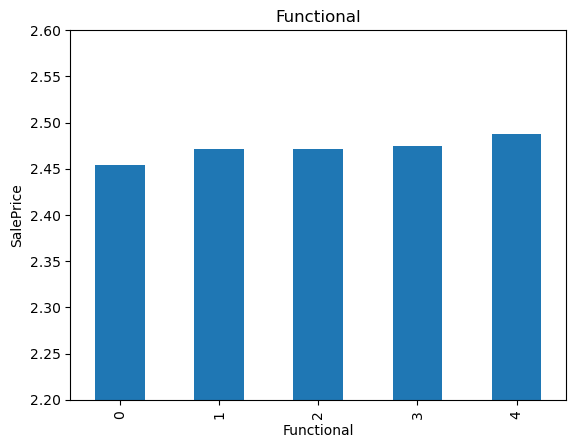

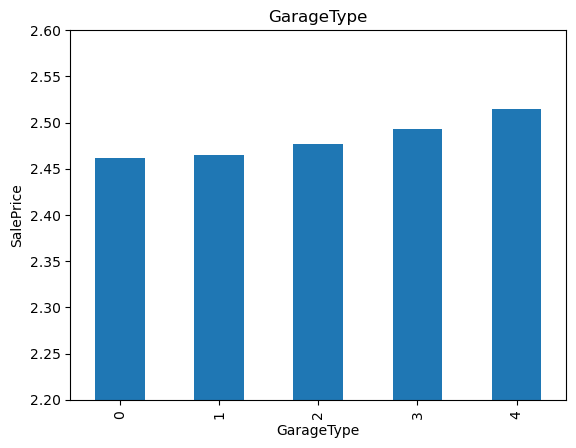

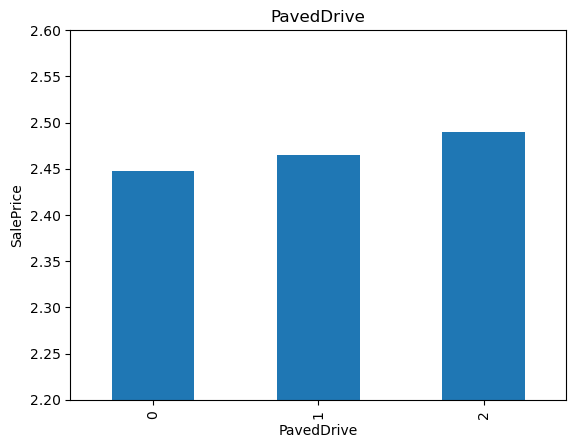

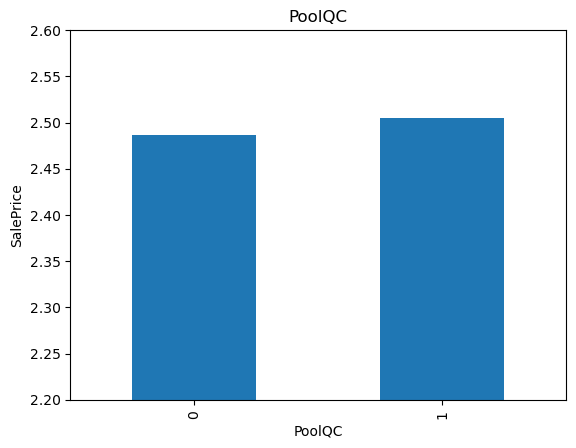

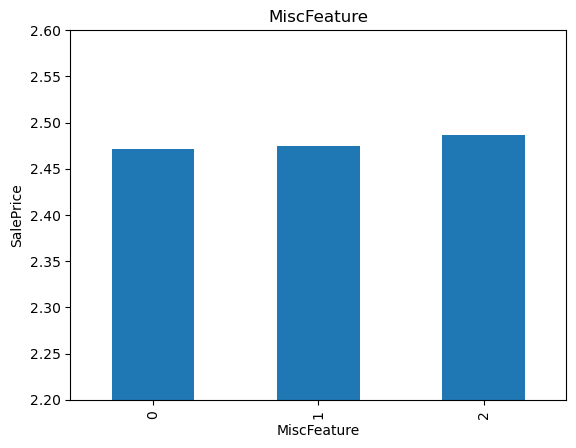

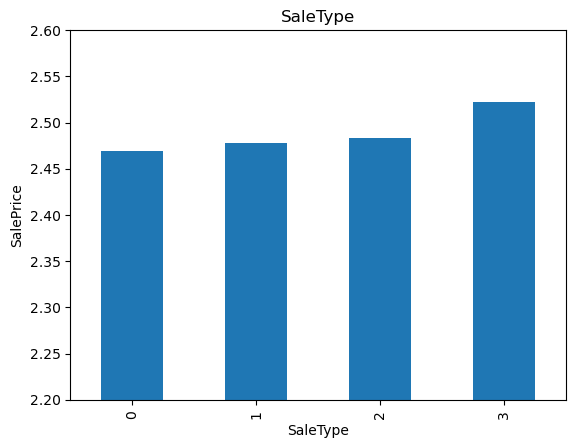

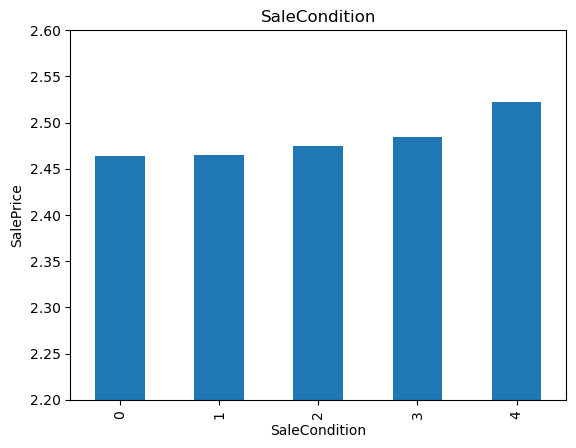

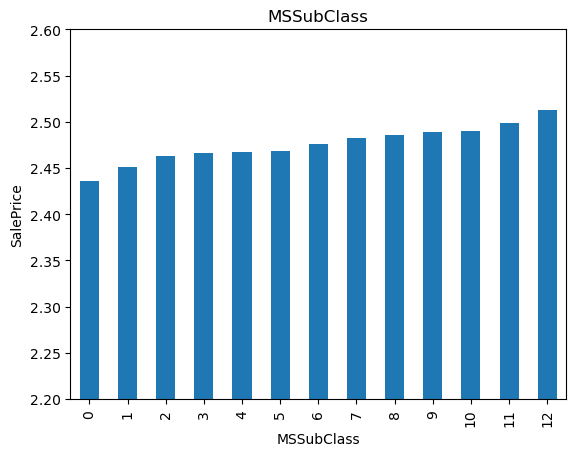

In [55]:
def analyse_vars(train, y_train, var):
    
    # function plots median house sale price per encoded
    # category
    
    tmp = pd.concat([X_train, np.log(y_train)], axis=1)
    
    tmp.groupby(var)['SalePrice'].mean().plot.bar()
    plt.title(var)
    plt.ylim(2.2, 2.6)
    plt.ylabel('SalePrice')
    plt.show()
    
for var in cat_others:
    analyse_vars(X_train, y_train, var)

The graphs show that the categories follow a monotonic relationship. Note how, the higher the integer that now represent the category, the higher the mean house sale price.

**Feature Scaling**

In [56]:
# Instantiate a Scaler
scaler = MinMaxScaler()

# fit the scaler to the train set
scaler.fit(X_train)

# transform the train and test set
# skaler returns numpy arrays, so we wrap the
# array with a pandas dataframe

X_train = pd.DataFrame(
    scaler.transform(X_train), 
    columns=X_train.columns
)

X_test = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_train.columns
)

In [57]:
X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition,LotFrontage_na,MasVnrArea_na,GarageYrBlt_na
0,0.750000,0.75,0.461171,0.377048,1.0,1.0,0.333333,1.000000,1.0,0.0,0.0,0.863636,0.4,1.0,0.75,0.6,0.777778,0.50,0.014706,0.049180,0.0,0.0,1.0,1.0,0.333333,0.00000,0.666667,0.5,1.0,0.666667,0.666667,0.666667,1.0,0.002835,0.0,0.0,0.673479,0.239935,1.0,1.00,1.0,1.0,0.559760,0.0,0.0,0.523250,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.416667,1.0,0.000000,0.0,0.75,0.018692,1.0,0.75,0.430183,0.5,0.5,1.0,0.116686,0.032907,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.545455,0.666667,0.75,0.0,0.0,0.0
1,0.750000,0.75,0.456066,0.399443,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.363636,0.4,1.0,0.75,0.6,0.444444,0.75,0.360294,0.049180,0.0,0.0,0.6,0.6,0.666667,0.03375,0.666667,0.5,0.5,0.333333,0.666667,0.000000,0.8,0.142807,0.0,0.0,0.114724,0.172340,1.0,1.00,1.0,1.0,0.434539,0.0,0.0,0.406196,0.333333,0.0,0.333333,0.5,0.375,0.333333,0.666667,0.250000,1.0,0.000000,0.0,0.75,0.457944,0.5,0.25,0.220028,0.5,0.5,1.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.75,1.0,0.0,0.636364,0.666667,0.75,0.0,0.0,0.0
2,0.916667,0.75,0.394699,0.347082,1.0,1.0,0.000000,0.333333,1.0,0.0,0.0,0.954545,0.4,1.0,1.00,0.6,0.888889,0.50,0.036765,0.098361,1.0,0.0,0.3,0.2,0.666667,0.25750,1.000000,0.5,1.0,1.000000,0.666667,0.000000,1.0,0.080794,0.0,0.0,0.601951,0.286743,1.0,1.00,1.0,1.0,0.627205,0.0,0.0,0.586296,0.333333,0.0,0.666667,0.0,0.250,0.333333,1.000000,0.333333,1.0,0.333333,0.8,0.75,0.046729,0.5,0.50,0.406206,0.5,0.5,1.0,0.228705,0.149909,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.090909,0.666667,0.75,0.0,0.0,0.0
3,0.750000,0.75,0.445002,0.493677,1.0,1.0,0.666667,0.666667,1.0,0.0,0.0,0.454545,0.4,1.0,0.75,0.6,0.666667,0.50,0.066176,0.163934,0.0,0.0,1.0,1.0,0.333333,0.00000,0.666667,0.5,1.0,0.666667,0.666667,1.000000,1.0,0.255670,0.0,0.0,0.018114,0.242553,1.0,1.00,1.0,1.0,0.566920,0.0,0.0,0.529943,0.333333,0.0,0.666667,0.0,0.375,0.333333,0.666667,0.250000,1.0,0.333333,0.4,0.75,0.084112,0.5,0.50,0.362482,0.5,0.5,1.0,0.469078,0.045704,0.0,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.636364,0.666667,0.75,1.0,0.0,0.0
4,0.750000,0.75,0.577658,0.402702,1.0,1.0,0.333333,0.333333,1.0,0.0,0.0,0.363636,0.4,1.0,0.75,0.6,0.555556,0.50,0.323529,0.737705,0.0,0.0,0.6,0.7,0.666667,0.17000,0.333333,0.5,0.5,0.333333,0.666667,0.000000,0.6,0.086818,0.0,0.0,0.434278,0.233224,1.0,0.75,1.0,1.0,0.549026,0.0,0.0,0.513216,0.000000,0.0,0.666667,0.0,0.375,0.333333,0.333333,0.416667,1.0,0.333333,0.8,0.75,0.411215,0.5,0.50,0.406206,0.5,0.5,1.0,0.000000,0.000000,0.0,1.0,0.0,0.0,0.0,0.00,1.0,0.0,0.545455,0.666667,0.75,0.0,0.0,0.0


In [58]:
# saving the train and test sets to a csv file

X_train.to_csv("xtrain.csv", index=False)
X_test.to_csv("xtest.csv", index=False)

y_train.to_csv("ytrain.csv", index=False)
y_test.to_csv("ytest.csv", index=False)

In [59]:
# saving the scaler
joblib.dump(scaler, "minmax_scaler.joblib")

['minmax_scaler.joblib']

In [63]:
!git push origin main

To https://github.com/Tobiodedere1211/House-Price-Advance-regression-technique-.git
   0fa5977..41bb59a  main -> main
